In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Importing useful libraries
import numpy as np
import os
import copy
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1 Breast Cancer Wisconsin Dataset

## 1.1 Loading the dataset 

In [2]:
from sklearn.datasets import load_breast_cancer

# Load as a sklearn bunch object
breast_cancer = load_breast_cancer()

# Convert to dataframe
cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
cancer['target'] = pd.Series(breast_cancer.target)

In [3]:
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 1.2 Investigating the Data

### 1.2.1 Feature Selection

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

<Axes: >

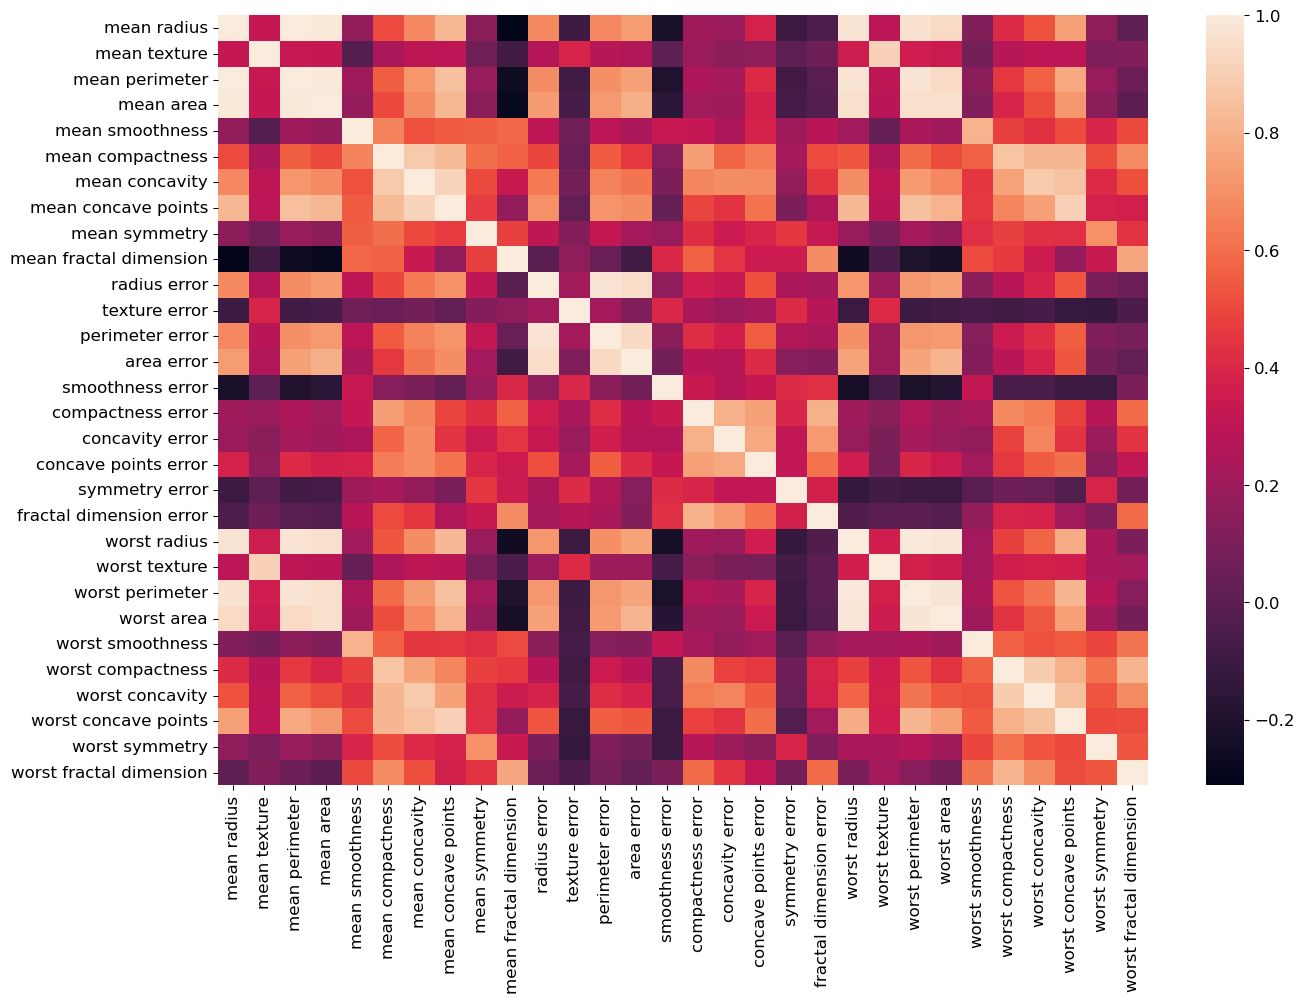

In [5]:
plt.figure(figsize=(15, 10))
sns.heatmap(cancer_copy.corr())

In [6]:
cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

cancer_copy.drop('mean perimeter', axis=1, inplace=True)
cancer_copy.drop('mean area', axis=1, inplace=True)
cancer_copy.drop('worst radius', axis=1, inplace=True)
cancer_copy.drop('worst perimeter', axis=1, inplace=True)
cancer_copy.drop('worst area', axis=1, inplace=True)
cancer_copy.drop('worst texture', axis=1, inplace=True)
cancer_copy.drop('worst concave points', axis=1, inplace=True)
cancer_copy.drop('worst concavity', axis=1, inplace=True)
cancer_copy.drop('worst compactness', axis=1, inplace=True)
cancer_copy.drop('perimeter error', axis=1, inplace=True)
cancer_copy.drop('area error', axis=1, inplace=True)
cancer_copy.drop('mean concave points', axis=1, inplace=True)
cancer_copy.drop('mean concavity', axis=1, inplace=True)
cancer_copy.drop('worst smoothness', axis=1, inplace=True)
cancer_copy.drop('compactness error', axis=1, inplace=True)

<Axes: >

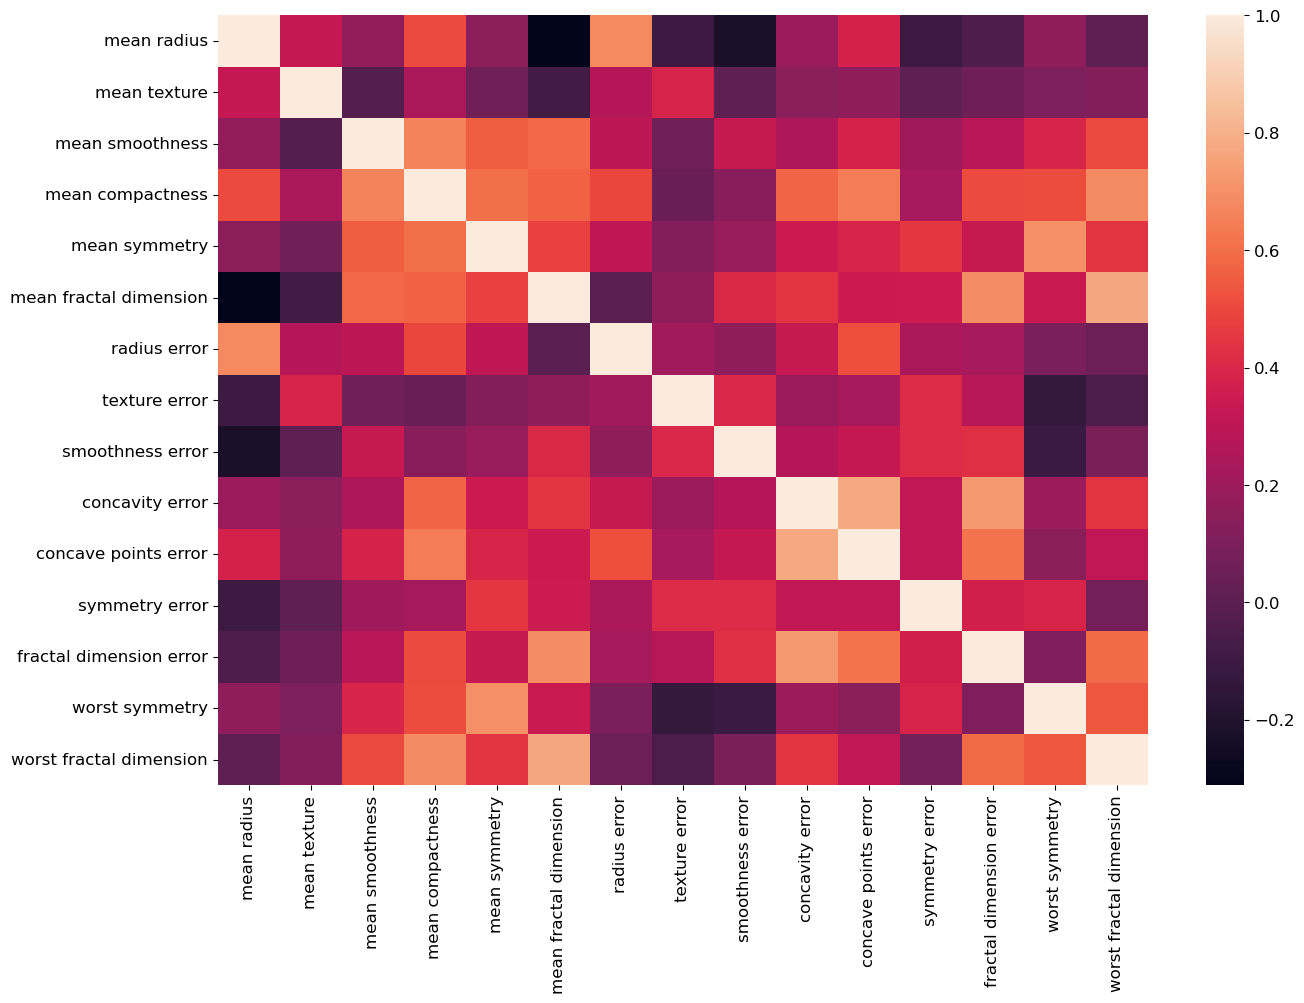

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(cancer_copy.corr())

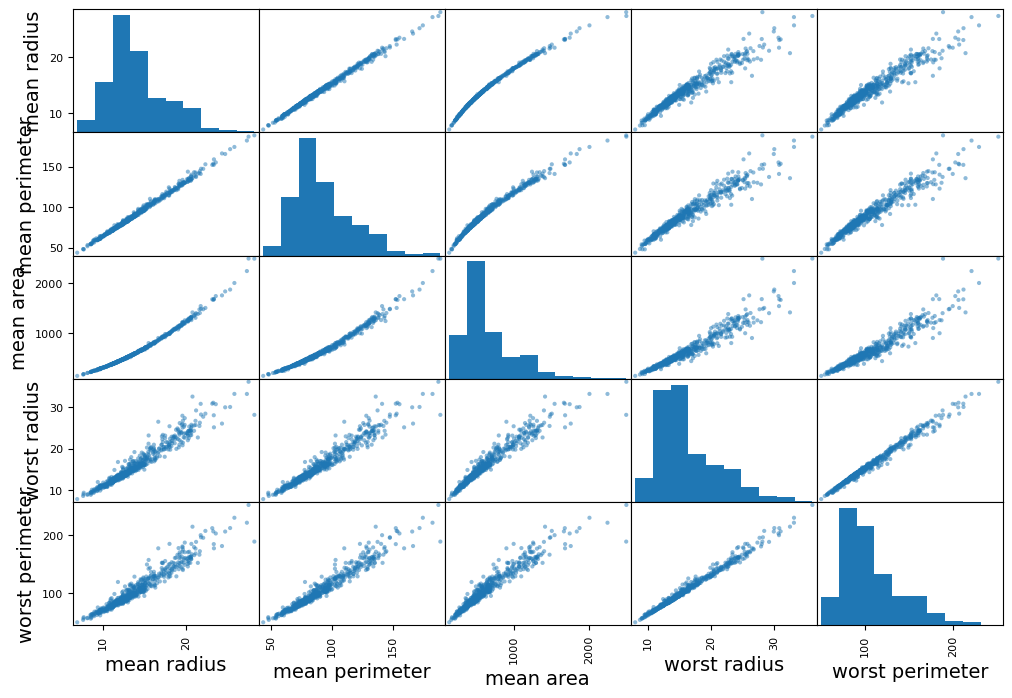

In [8]:
from pandas.plotting import scatter_matrix

attributes = ['mean radius', 'mean perimeter', 'mean area', 'worst radius', 'worst perimeter']

scatter_matrix(cancer[attributes], figsize=(12,8))
plt.show()

### 1.3.1 Preparing the training and test sets

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
cancer_train_X, cancer_test_X, cancer_train_y, cancer_test_y = train_test_split(cancer_copy, cancer['target'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func = StandardScaler()

cancer_train_X = scaler_func.fit_transform(cancer_train_X)
cancer_test_X = scaler_func.transform(cancer_test_X)

## 1.3 Decision Trees

### 1.3.1 Default Hyperparameters

The following cells will involve training a decision tree classifier on the selected features using the default hyper parameters

In [10]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

tree_default = DecisionTreeClassifier()
tree_default.fit(cancer_train_X, cancer_train_y)

y_pred_train_default = tree_default.predict(cancer_train_X)
accuracy_train_default = accuracy_score(cancer_train_y, y_pred_train_default)

y_pred_test_default = tree_default.predict(cancer_test_X)
accuracy_test_default = accuracy_score(cancer_test_y, y_pred_test_default)

print('The accuracy on the training set:', accuracy_train_default)
print('The accuracy on the testing set:', accuracy_test_default)

The accuracy on the training set: 1.0
The accuracy on the testing set: 0.8953488372093024


In [11]:
# import graphviz
# from sklearn.tree import export_graphviz

# dot_data = tree.export_graphviz(tree_default, out_file=None, 
#                      feature_names=cancer_copy.columns,  
#                      class_names=['0', '1'],  
#                      filled=True, rounded=True,  
#                      special_characters=True)  

# graph = graphviz.Source(dot_data)  
# graph 

### 1.3.2 Restricting Depth to 3

In [12]:
tree_depth = DecisionTreeClassifier(max_depth=3)
tree_depth.fit(cancer_train_X, cancer_train_y)

y_pred_train_depth = tree_depth.predict(cancer_train_X)
accuracy_train_depth = accuracy_score(cancer_train_y, y_pred_train_depth)

y_pred_test_depth = tree_depth.predict(cancer_test_X)
accuracy_test_depth = accuracy_score(cancer_test_y, y_pred_test_depth)

print('The accuracy on the training set:', accuracy_train_depth)
print('The accuracy on the testing set:', accuracy_test_depth)

The accuracy on the training set: 0.9523809523809523
The accuracy on the testing set: 0.8837209302325582


### 1.3.3 Setting Min Samples Split  to 5

In [13]:
tree_split = DecisionTreeClassifier(min_samples_split=5)
tree_split.fit(cancer_train_X, cancer_train_y)

y_pred_train_split = tree_split.predict(cancer_train_X)
accuracy_train_split = accuracy_score(cancer_train_y, y_pred_train_split)

y_pred_test_split = tree_split.predict(cancer_test_X)
accuracy_test_split = accuracy_score(cancer_test_y, y_pred_test_split)

print('The accuracy on the training set:', accuracy_train_split)
print('The accuracy on the testing set:', accuracy_test_split)

The accuracy on the training set: 0.9958592132505176
The accuracy on the testing set: 0.9069767441860465


### 1.3.4 Setting Min Samples Leaf to 5

In [14]:
tree_leaf = DecisionTreeClassifier(min_samples_leaf=5)
tree_leaf.fit(cancer_train_X, cancer_train_y)

y_pred_train_leaf = tree_leaf.predict(cancer_train_X)
accuracy_train_leaf = accuracy_score(cancer_train_y, y_pred_train_leaf)

y_pred_test_leaf = tree_leaf.predict(cancer_test_X)
accuracy_test_leaf = accuracy_score(cancer_test_y, y_pred_test_leaf)

print('The accuracy on the training set:', accuracy_train_leaf)
print('The accuracy on the testing set:', accuracy_test_leaf)

The accuracy on the training set: 0.9668737060041408
The accuracy on the testing set: 0.8837209302325582


## 1.4 Using Cross-Validation to find best hyperparameters

In [15]:
from sklearn.model_selection import GridSearchCV

# Create a new Decision Tree Classifier
tree = DecisionTreeClassifier()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=3, scoring='accuracy')
# Fit the grid search object to the training data
grid_search.fit(cancer_train_X, cancer_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 4}
Best cross-validation score: 0.9151138716356108


## 1.5 Training Model on best Hyperparameters

In [16]:
tree_best = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=2)
tree_best.fit(cancer_train_X, cancer_train_y)

y_pred_train_best = tree_best.predict(cancer_train_X)
accuracy_train_best = accuracy_score(cancer_train_y, y_pred_train_best)

y_pred_test_best = tree_best.predict(cancer_test_X)
accuracy_test_best = accuracy_score(cancer_test_y, y_pred_test_best)

print('The accuracy on the training set:', accuracy_train_best)
print('The accuracy on the testing set:', accuracy_test_best)

The accuracy on the training set: 0.9668737060041408
The accuracy on the testing set: 0.8837209302325582


## 1.6 Comparison

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

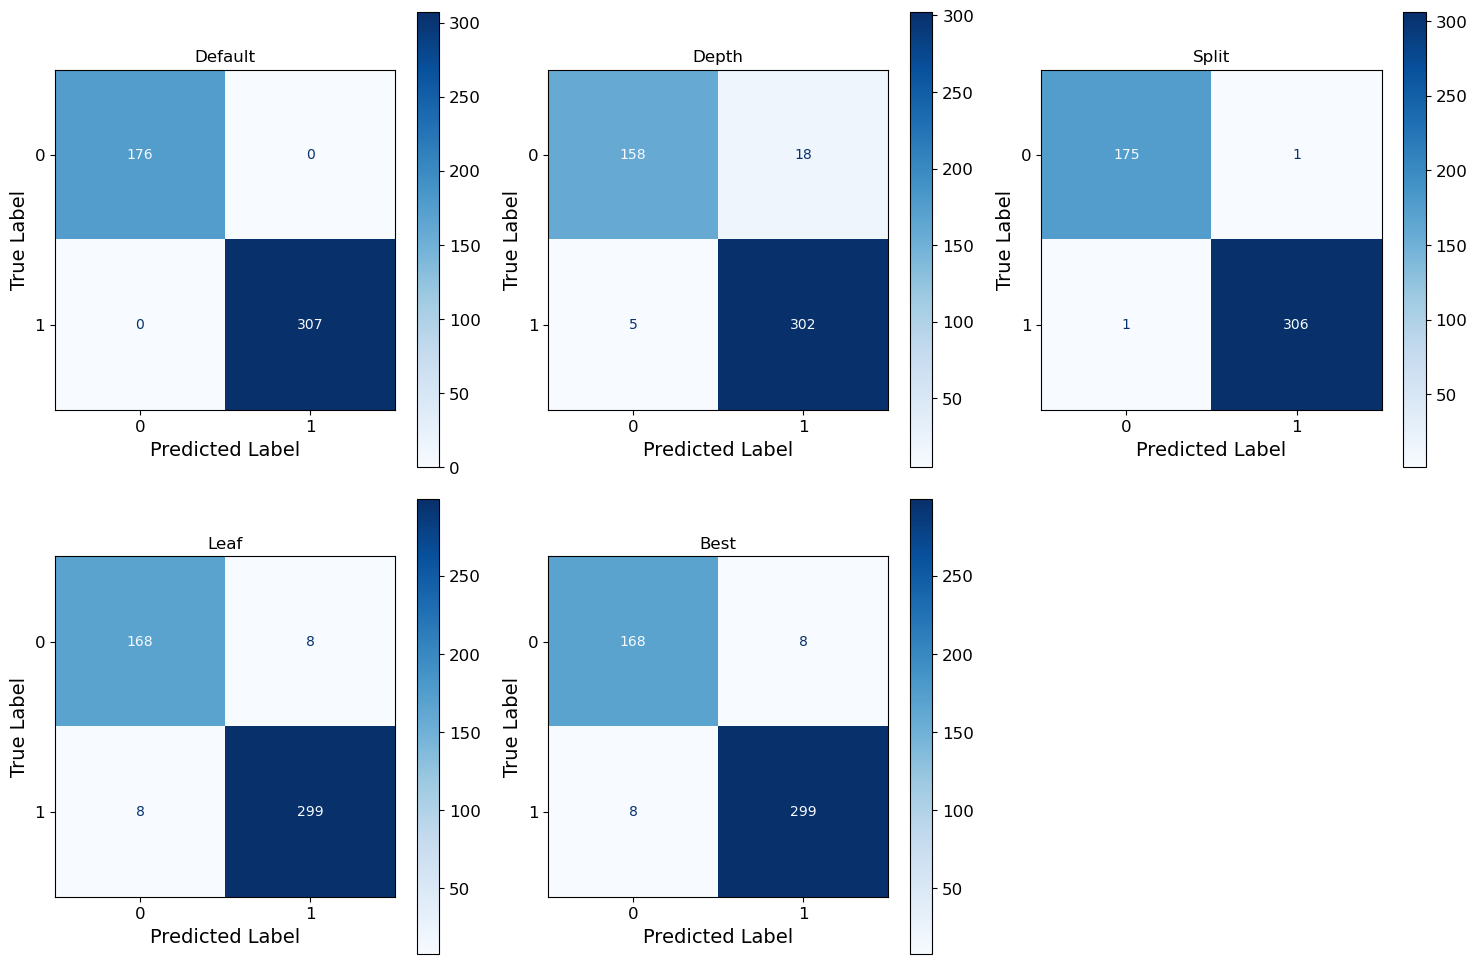

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define your predictions
predictions = [y_pred_train_default, y_pred_train_depth, y_pred_train_split, y_pred_train_leaf, y_pred_train_best]
labels = ['Default', 'Depth', 'Split', 'Leaf', 'Best']
labels = ['Default', 'Depth', 'Split', 'Leaf', 'Best']

# Create the figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each axis and plot the corresponding confusion matrix
for i, ax in enumerate(axs.ravel()):
    if i < len(predictions):
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(cancer_train_y, predictions[i])

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(ax=ax, cmap='Blues', values_format='.0f')
        disp.ax_.set_xlabel('Predicted Label')
        disp.ax_.set_ylabel('True Label')
        disp.ax_.set_title(labels[i])
    
# Add some space between the plots and show the figure
fig.tight_layout()
fig.delaxes(axs[1][2])
plt.show()

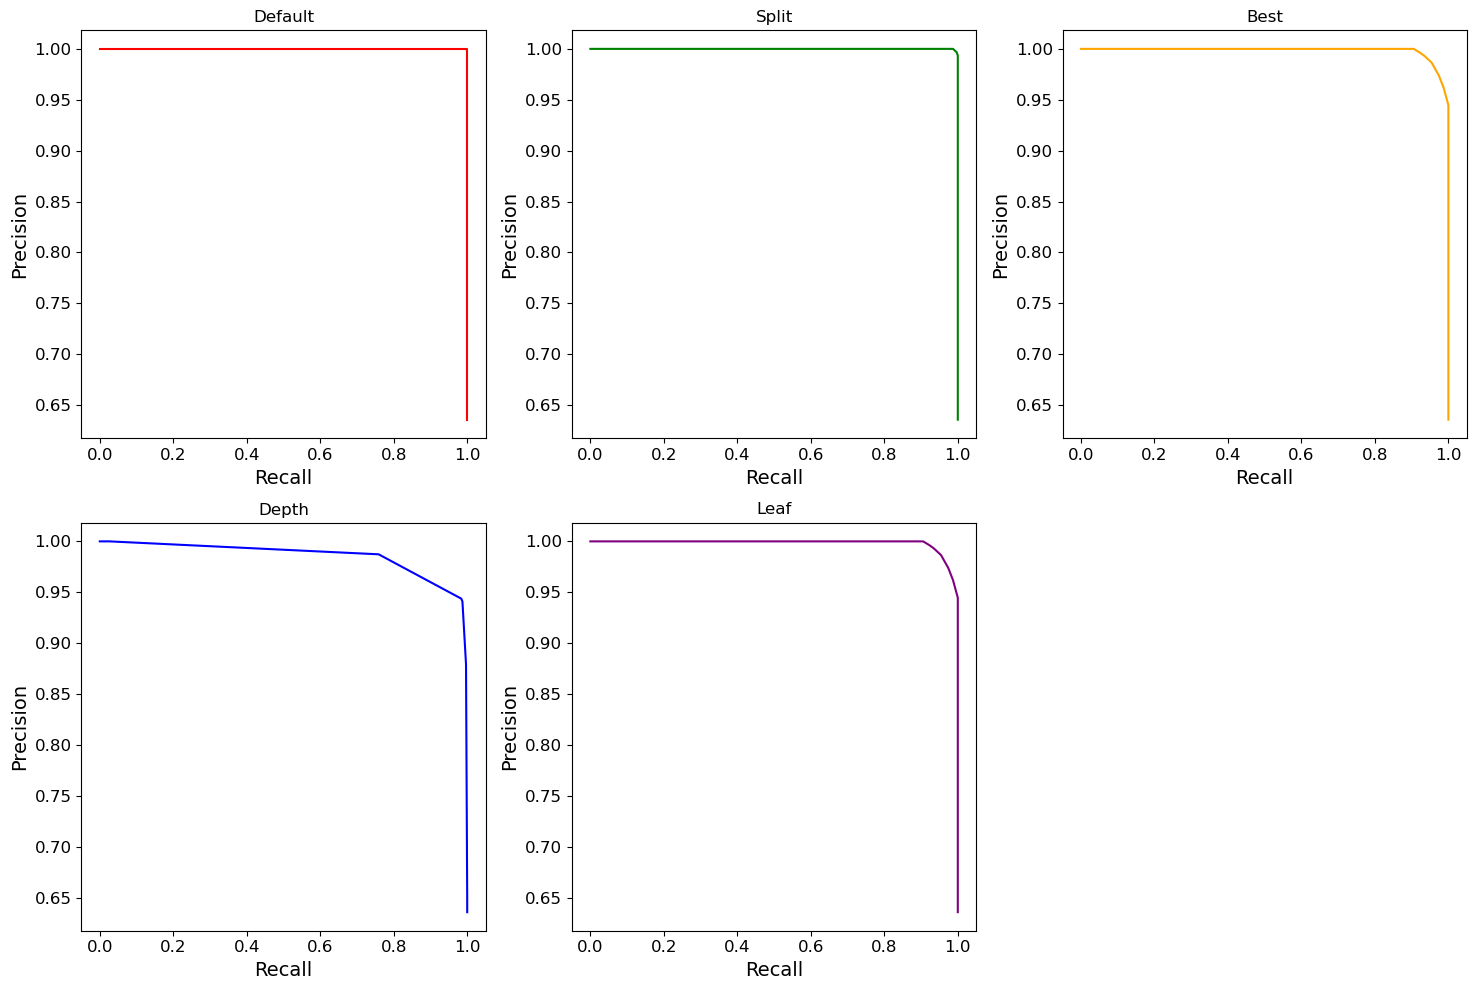

In [19]:
from sklearn.metrics import precision_recall_curve

classifiers = [tree_default, tree_depth, tree_split, tree_leaf, tree_best]
labels = ['Default', 'Depth', 'Split', 'Leaf', 'Best']
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Create the figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each classifier and plot its precision-recall curve on a separate plot
for i, clf in enumerate(classifiers):
    # Calculate the precision-recall curve
    y_pred_proba = clf.predict_proba(cancer_train_X)[:, 1]
    precision, recall, _ = precision_recall_curve(cancer_train_y, y_pred_proba)
    
    # Determine the subplot indices for this curve
    row = i // 2
    col = i % 2
    
    # Plot the precision-recall curve on the subplot
    ax = axs[col, row]
    ax.plot(recall, precision, color=colors[i])
    ax.set_title(labels[i])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

# Add some space between the plots and show the figure
fig.tight_layout()
fig.delaxes(axs[1][2])
plt.show()

# 2 Concrete Slump Dataset

In [20]:
concrete_data = pd.read_csv('slump_test.data')
concrete_data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [21]:
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.0 KB

By inspection of the dataset, the 'No' column is an instance label which is not part of the classification task. Therefore, we will remove this along with the other two output columns. 

In [22]:
# Dropping the index col
concrete_data.drop('No', axis=1, inplace=True)
# Dropping the other 2 targets
concrete_data.drop('SLUMP(cm)', axis=1, inplace=True)
concrete_data.drop('FLOW(cm)', axis=1, inplace=True)

## 2.1 Visualizing the Data

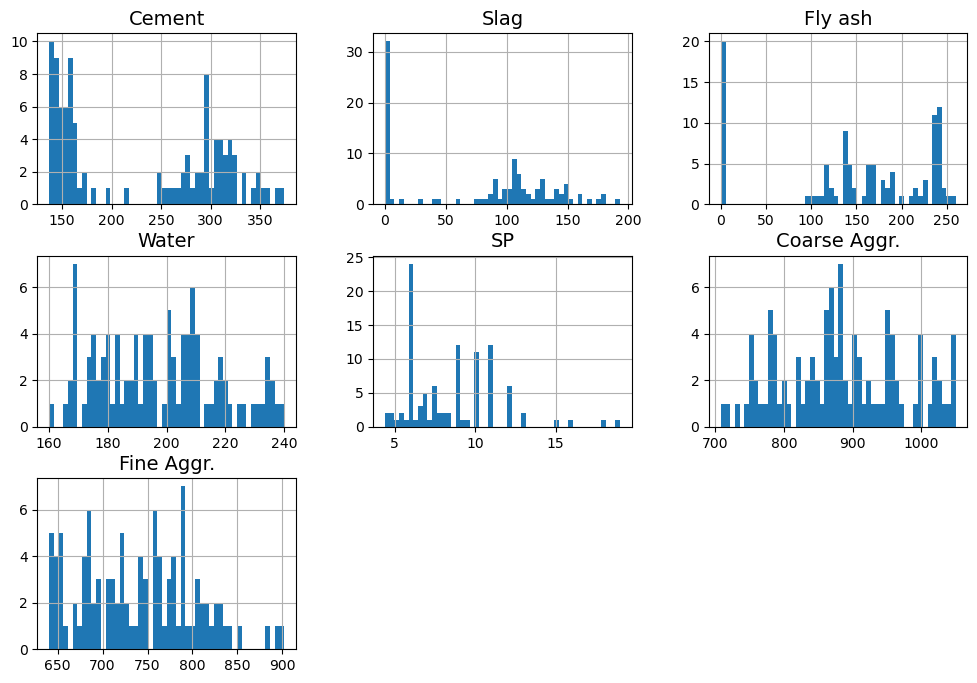

In [23]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

## 2.2 Splitting the Data

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Splitting the dataset into a training set (80%) and a testing set (20%) randomstate=123
con_train_X, con_test_X, con_train_y, con_test_y = train_test_split(concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1), concrete_data['Compressive Strength (28-day)(Mpa)'], test_size=0.20, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_1 = MinMaxScaler(feature_range=(0,1))

con_train_X = scaler_func.fit_transform(con_train_X)
con_test_X = scaler_func.transform(con_test_X)

#Transform back into a pd dataframe
feature_cols = ["Cement","Slag","Fly ash","Water","SP","Coarse Aggr.","Fine Aggr."]
con_train_X=pd.DataFrame(con_train_X, columns=feature_cols)
con_test_X=pd.DataFrame(con_test_X, columns=feature_cols)


## 2.3 Estimators with default parameters

In this section, a linear SVM regressor, linear regressor and a stochastic gradient descent regressor were trained using their default hyperparameters. A voting regressor based on the aforementioned three regressors was also trained using default parameters. 

In [25]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor

con_svr = SVR(kernel='linear')
con_lin = LinearRegression()
con_sgd = SGDRegressor()
con_voting = VotingRegressor([('Linear_SVR', con_svr), ('Linear-Reg', con_lin), ('SGD_Reg', con_sgd)])

con_lin.fit(con_train_X, con_train_y)
con_svr.fit(con_train_X, con_train_y)
con_sgd.fit(con_train_X, con_train_y)
con_voting.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR', SVR(kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor())])

### 2.3.1 Results and plots

In [26]:
from sklearn.metrics import mean_squared_error

def plot_con_predictions(regressors):
    rmse = []
    indexes = np.arange(0,21,1)

    plt.plot(indexes, con_test_y, label="GroundTruth")

    for reg in regressors:
        y_pred = reg.predict(con_test_X)
        rmse_val = np.sqrt(mean_squared_error(con_test_y, y_pred))
        rmse.append(rmse_val)
        plt.plot(indexes, y_pred, label=reg.__class__.__name__)
        print("RMSE value for {} regressor is: {}".format(reg.__class__.__name__, rmse_val))

    plt.legend(loc='best', fontsize=8)
    plt.xlabel("Index", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.title("Predict Values", fontsize=15)
    plt.show()
    
    return rmse

In [27]:
def plot_con_bars(rmse):
    labels = ['Linear_SVR', 'Linear-Reg', 'SGD_Reg', 'Voting_Reg']

    colors = ['b', 'g', 'r', 'y']

    fig, ax = plt.subplots()

    # create a bar chart with labels, rmse values, and colors
    ax.bar(labels, rmse, color=colors)

    # add the truncated rmse values on top of each bar
    for i, v in enumerate(rmse):
        ax.text(i, v + 0.1, str(round(v, 5)), ha='center', fontsize=10)

    # set the title and axis labels
    ax.set_title('RMSE Values')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')

    # display the plot
    plt.show()

RMSE value for SVR regressor is: 2.9104631777060246
RMSE value for LinearRegression regressor is: 3.2938784151981375
RMSE value for SGDRegressor regressor is: 3.1807805246122767
RMSE value for VotingRegressor regressor is: 3.1279753074501158


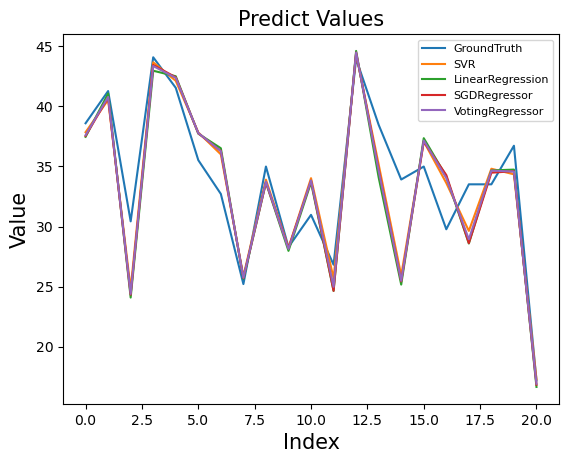

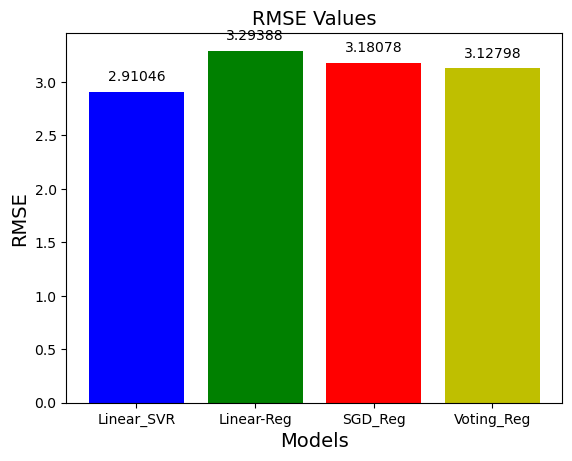

In [28]:
regressors = [con_svr, con_lin, con_sgd, con_voting]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

## 2.4 Tuning Hyperparameters

### 2.4.1 Linear SVR Regressor

In [29]:
svr = SVR(kernel='linear')

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'C': 10, 'epsilon': 1}
Best cross-validation score: -2.529991601729001


### 2.4.2 SGD Regressor

In [30]:
sgd = SGDRegressor()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'alpha': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(sgd, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 1e-05}
Best cross-validation score: -2.6562366872711234


### 2.4.3 Estimators with tuned parameters

In [31]:
con_svr_tuned = SVR(kernel='linear', C=10, epsilon=1)
con_lin_tuned = LinearRegression()
con_sgd_tuned = SGDRegressor(alpha=0.00000001)
con_voting_tuned = VotingRegressor([('Linear_SVR', con_svr_tuned), ('Linear-Reg', con_lin_tuned), ('SGD_Reg', con_sgd_tuned)])

con_lin_tuned.fit(con_train_X, con_train_y)
con_svr_tuned.fit(con_train_X, con_train_y)
con_sgd_tuned.fit(con_train_X, con_train_y)
con_voting_tuned.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR',
                             SVR(C=10, epsilon=1, kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor(alpha=1e-08))])

RMSE value for SVR regressor is: 3.5007749804403128
RMSE value for LinearRegression regressor is: 3.2938784151981375
RMSE value for SGDRegressor regressor is: 3.1811220864066505
RMSE value for VotingRegressor regressor is: 3.3145580466709643


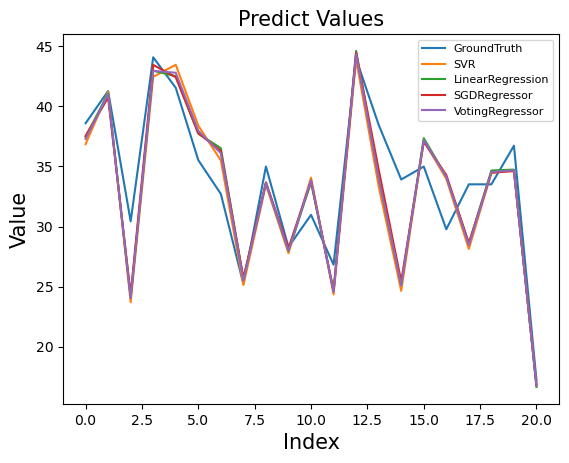

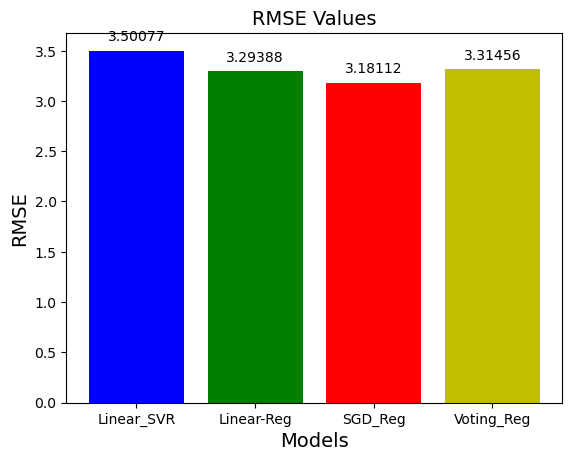

In [32]:
regressors = [con_svr_tuned, con_lin_tuned, con_sgd_tuned, con_voting_tuned]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

# 3 Abalone Dataset

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Read in data
ab_data = pd.read_csv('abalone.data')
# Col names from https://archive.ics.uci.edu/ml/datasets/Abalone
col_names = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]
ab_data.columns=col_names

# Creating an instance of the ordinal encoder 
enc = OrdinalEncoder(categories=[['M','F','I']])
ab_data['Sex'] = enc.fit_transform(ab_data['Sex'].values.reshape(-1,1))

ab_data.head()

,Sex,Length,Diameter continuous,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,0.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,2.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,2.0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


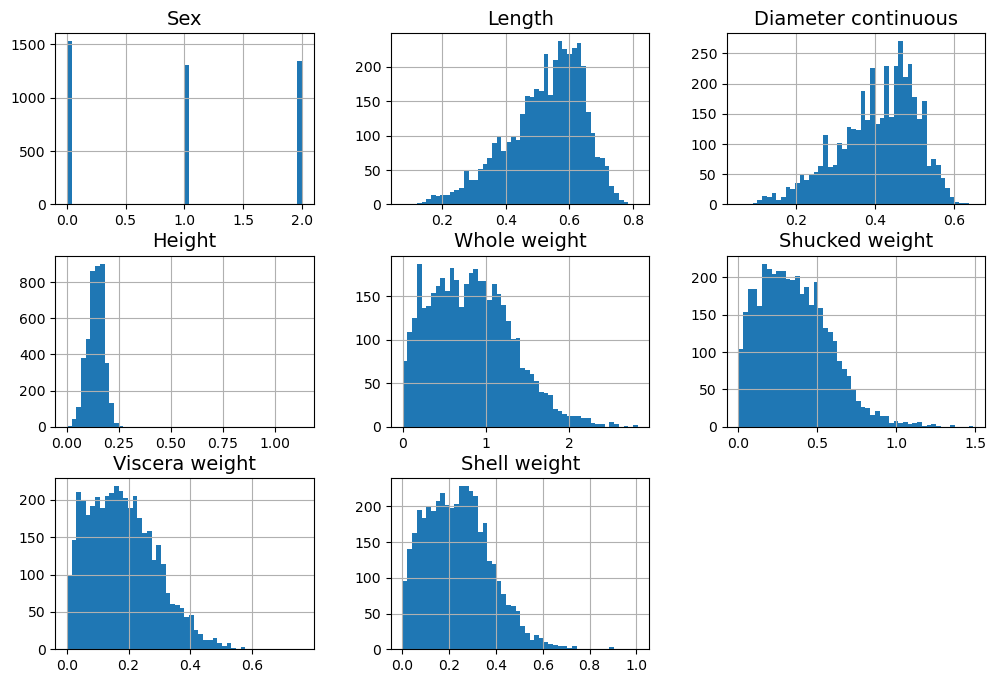

In [34]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

ab_data.drop('Rings', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

In [35]:
# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
ab_train_X, ab_test_X, ab_train_y, ab_test_y = train_test_split(ab_data.drop('Rings', axis=1), ab_data['Rings'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_2 = MinMaxScaler(feature_range=(0,1))

ab_train_X = scaler_func.fit_transform(ab_train_X)
ab_test_X = scaler_func.transform(ab_test_X)

#Transform back into a pd dataframe
feature_cols = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight"]
ab_train_X=pd.DataFrame(ab_train_X, columns=feature_cols)
ab_test_X=pd.DataFrame(ab_test_X, columns=feature_cols)

## 3.1 Tuning Max_Depth

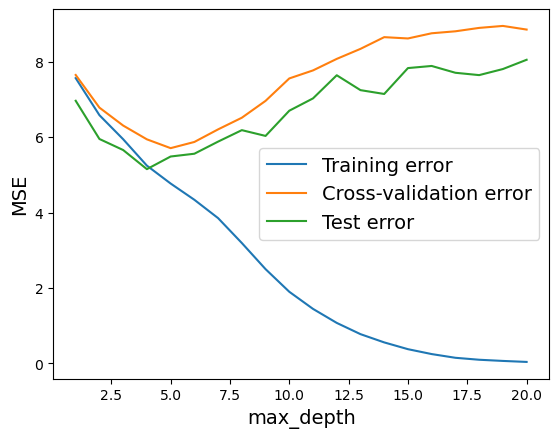

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Set the range of max_depth values to test
max_depths = range(1, 21)

# Initialize empty lists to store the errors
train_errors = []
cv_errors = []
test_errors = []

# Loop through each value of max_depth and fit a decision tree regression model
for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
    cv_error = -1 * cv_scores.mean()
    cv_errors.append(cv_error)
    
    # Fit the model on the training data and evaluate its performance on the training set
    dt.fit(ab_train_X, ab_train_y)
    train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
    train_errors.append(train_error)
    
    # Evaluate the model on the test data
    test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
    test_errors.append(test_error)

# Plot the errors as a function of max_depth
plt.plot(max_depths, train_errors, label='Training error')
plt.plot(max_depths, cv_errors, label='Cross-validation error')
plt.plot(max_depths, test_errors, label='Test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3.2 Tuning Min_Samples_Leaf

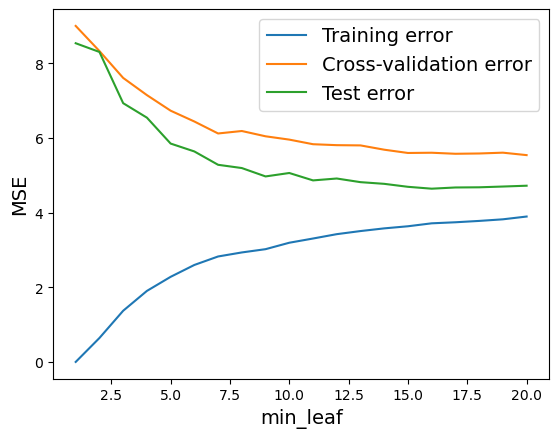

In [46]:
# Set the range of min_leaf values to test
min_leafs = range(1, 21)

# Initialize empty lists to store the errors
train_errors = []
cv_errors = []
test_errors = []

# Loop through each value of min_leaf and fit a decision tree regression model
for min_leaf in min_leafs:
    dt = DecisionTreeRegressor(min_samples_leaf=min_leaf)
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
    cv_error = -1 * cv_scores.mean()
    cv_errors.append(cv_error)
    
    # Fit the model on the training data and evaluate its performance on the training set
    dt.fit(ab_train_X, ab_train_y)
    train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
    train_errors.append(train_error)
    
    # Evaluate the model on the test data
    test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
    test_errors.append(test_error)

# Plot the errors as a function of min_leaf
plt.plot(min_leafs, train_errors, label='Training error')
plt.plot(min_leafs, cv_errors, label='Cross-validation error')
plt.plot(min_leafs, test_errors, label='Test error')
plt.xlabel('min_leaf')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3.3 Random Forest with 500 Estimators 

The following cell takes a very long time to run and has been commented out. The 4 hyperparameters have been chosen for this grid search using 3 fold cross validation and the best parameters have been found:

- booststrap: True
- max_depth: 16
- max_features: log2
- min_samples_leaf: 4

In [50]:
from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor()

# # Define the hyperparameters and their possible values for grid search
# param_grid = {
#     'max_depth': range(1, 21),
#     'min_samples_leaf': range(1, 21),
#     'max_features': [1.0, 'sqrt', 'log2'],
#     'bootstrap': [True, False]  
# }

# # Create a grid search object with 3-fold cross-validation
# grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# # Fit the grid search object to the training data
# grid_search.fit(ab_train_X, ab_train_y)

# # Print the best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)

# # Print the best cross-validation score
# print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 4}
Best cross-validation score: -2.1559213850370083


In [56]:
# Create a random forest regressor with best hyperparameters
forest = RandomForestRegressor(max_depth=16, bootstrap=True, max_features='log2', min_samples_leaf=4)
# fit regressor to training data
forest.fit(ab_train_X, ab_train_y)
# predict on test set
y_pred = forest.predict(ab_test_X)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.031199162510781


## 3.4 Feature Selection